In [1]:
import ee
import pandas as pd 
import numpy as np
import folium
from folium import plugins

### Calculating Evapotranspiration using Landsat 
1. We will calculate ET using the residual energy balance method 
- Net radiation (Rn)
- Soil Heat flux (G)
- Sensible Heat flux (H)

Then calculate $ LE=R_{n} - H - G $

### 1. Process Landsat 
- Select a Landsat Image
- Visualize 
- Get details 
- Cloud Mask 


In [2]:
# ee.Initialize()
import sys
sys.path.append('D:\\Backup\\Rouhin_Lenovo\\US_project\\GEE_SEBAL_Project\\geeSEBAL_copy_edits\\etbrasil\\')
import geesebal
from geesebal import (tools,landsatcollection,masks,meteorology,endmembers, 
evapotranspiration,collection,timeseries,image,ET_Collection_mod)

In [3]:
import geopandas as gpd
import geemap

In [4]:
# pvid=gpd.read_file("C:\\Users\\rouhi\\Downloads\\PVID\\pvid.shp")
# pvid.plot()
# pvid_ee=geemap.shp_to_ee(pvid)
geometry_shp = "C:\\Users\\rouhi\\Downloads\\PVID\\pvid.shp"
pvid_ee = geemap.shp_to_ee(geometry_shp)

In [5]:
# Get a <10% cloudy landsat image of the central valley 
# LANDSAT/LC08/C02/T1_L2/LC08_043034_20220402
# geometry=ee.Geometry.Point([ 33.368644,14.501638])
# geometry=ee.Geometry.Point([-120.9508,38.4133]) # US vaira
geometry=ee.Geometry.Point([ -121.550491,38.382768]) # Neutral to accomodate Bi1 and Vaira
# geometry=ee.Geometry.Point([ 2.224813,13.586435]) # Niger

lat=13.586435
lon=2.224813
# geometry=ee.Geometry.Point([ -114.636762,33.505823]) # PVID




	
# Get the image collection 
ls=ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterDate("2022-04-01","2022-09-30").filterMetadata('CLOUD_COVER', 'less_than', 5).filterBounds(geometry);
print("The image collection has", ls.size().getInfo(), "images")
## Scale the images 
## Why do we need to scale? (Refer the slides)
def applyScaleFactors(image):
        opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2);
        thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0);
        return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)
ls=ls.map(applyScaleFactors)
#Get the first image
ls_first=ls.first()

The image collection has 6 images


#### Visualize Image

In [6]:
# Add custom basemaps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )}
# Map.addLayer(pvid_ee, {}, 'Region of Interest')


In [7]:
# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [8]:
# Set visualization parameters.
# vis_params = {
#   'min': 0,
#   'max': 4000,
#   'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}
vis_params = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0.0,
  'max': 0.3,
};
# Create a folium map object.
my_map = folium.Map(location=[14.501638, 33.368644], zoom_start=4, height=500)

# Add custom basemaps
basemaps['Google Maps'].add_to(my_map)
basemaps['Google Satellite Hybrid'].add_to(my_map)

# Add the elevation model to the map object.
my_map.add_ee_layer(ls_first, vis_params, 'True Color composite Image')
my_map.add_ee_layer(pvid_ee, {}, 'PVID')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(my_map)

# Display the map.
display(my_map)

In [16]:
### Get Image details 
landsat_version=ls_first.get('L1_LANDSAT_PRODUCT_ID').getInfo()
print(landsat_version)
sun_elevation=ls_first.get("SUN_ELEVATION")
print("Sun Elevation ", sun_elevation.getInfo())
time_start=ls_first.get('system:time_start')
date=ee.Date(time_start)
year=ee.Number(date.get('year'))
month=ee.Number(date.get('month'))
day=ee.Number(date.get('day'))
hour=ee.Number(date.get('hour'))
minuts = ee.Number(date.get('minutes'))
print("Time of Image ", day.getInfo(),"/",month.getInfo(),"/",year.getInfo(), "@" , hour.getInfo(), ":",minuts.getInfo())

LC08_L1TP_044033_20220409_20220419_02_T1
Sun Elevation  53.7136277
Time of Image  9 / 4 / 2022 @ 18 : 45


In [17]:
def H_zom_2(image, ux, UR, Rn24hobs, n_Ts_cold, d_hot_pixel, date_string, refpoly):

    #VEGETATION HEIGHTS  [M]
    n_veg_hight = ee.Number(3)

    #WIND SPEED AT HEIGHT Zx [M]
    n_zx = ee.Number(2)

    #BLENDING HEIGHT [M]
    n_hight = ee.Number(200)

    #AIR SPECIFIC HEAT [J kg-1/K-1]
    n_Cp = ee.Number(1004)

    #VON KARMAN'S CONSTANT
    n_K = ee.Number(0.41)

    #TS COLD PIXEL
    n_Ts_cold = ee.Number(n_Ts_cold)
    #TS HOT PIXEL
    n_Ts_hot = ee.Number(d_hot_pixel.get('temp'))
    #G HOT PIXEL
    n_G_hot = ee.Number(d_hot_pixel.get('G').getInfo())
    #RN HOT PIXEL
    n_Rn_hot = ee.Number(d_hot_pixel.get('Rn').getInfo())
    #LAT AND LON HOT PIXEL
    n_long_hot = ee.Number(d_hot_pixel.get('x').getInfo())
    n_lat_hot = ee.Number(d_hot_pixel.get('y').getInfo())
    #POINT GEOMETRY
    p_hot_pix =  ee.Geometry.Point([n_long_hot, n_lat_hot])

    #SAVI
    i_savi = image.select('SAVI')

    #MOMENTUM ROUGHNESS LENGHT (ZOM) AT THE WEATHER STATION [M]
    #BRUTSAERT (1982)
    n_zom =  n_veg_hight.multiply(0.12)

    #FRICTION VELOCITY AT WEATHER STATION [M S-1]
    i_ufric_ws = i_savi.expression(
      '(n_K * ux)/ log(n_zx /n_zom)', {
              'n_K': n_K,
              'n_zx': n_zx,
              'n_zom': n_zom,
              'ux': ux }).rename('ufric_ws')

    #WIND SPEED AT BLENDING HEIGHT AT THE WEATHER STATION [M S-1]
    i_u200 = i_savi.expression(
      'i_ufric_ws *  (log(n_hight/n_zom)/n_K)', {
              'i_ufric_ws' : i_ufric_ws,
              'n_hight' : n_hight,
              'n_zom' : n_zom,
              'n_K' : n_K}).rename('i_u200')

    #MOMENTUM ROUGHNESS LENGHT (ZOM) FOR EACH PIXEL [M]
    i_zom = i_savi.expression(
     'exp((5.62 * (SAVI))-5.809)', {
              'SAVI' : i_savi,}).rename('zom')
    #ADD BAND
    image=image.addBands(i_zom.select('zom'))

    #FRICTION VELOCITY FOR EACH PIXEL  [M S-1]
    i_ufric = i_savi.expression(
      '(n_K *u200) /(log(hight/i_zom))', {
              'u200' : i_u200,
              'hight': n_hight,
              'i_zom':i_zom,
              'n_K': n_K }).rename('u_fr')
    #ADD BAND
    image=image.addBands(i_ufric.select('u_fr'))
    #AERODYNAMIC RESISTANCE TO HEAT TRANSPORT (rah) [S M-1]

    #Z1 AND Z2 ARE HEIGHTS [M] ABOVE THE ZERO PLANE DISPLACEMENT
    #OF THE VEGETATION
    z1= ee.Number(0.1);
    z2= ee.Number(4);
    i_rah = i_ufric.expression(
      '(log(z2/z1))/(i_ufric*0.41)', {
              'z2' : z2,
              'z1': z1,
              'i_ufric':i_ufric }).rename('rah')

    i_rah_first = i_rah.rename('rah_first')

    #AIR DENSITY HOT PIXEL
    n_ro_hot= (ee.Number(-0.0046).multiply(n_Ts_hot)).add(ee.Number(2.5538))

    #========ITERATIVE PROCESS=========#

    #SENSIBLE HEAT FLUX AT THE HOT PIXEL (H_hot)
    n_H_hot = ee.Number(n_Rn_hot).subtract(ee.Number(n_G_hot))

    #ITERATIVE VARIABLES
    n= ee.Number(1)
    n_dif= ee.Number(1)
    n_dif_min = ee.Number(0.1)
    list_dif = ee.List([])
    list_dT_hot = ee.List([])
    list_rah_hot = ee.List([])
    list_coef_a = ee.List([])
    list_coef_b = ee.List([])

    #NUMBER OF ITERATIVE STEPS: 15
    #CAN BE CHANGED, BUT BE AWARE THAT
    #A MINIMUM NUMBER OF ITERATIVE PROCESSES
    #IS NECESSARY TO ACHIEVE RAH AND H ESTIMATIONS

    #========INIT ITERATION========#
    for n in range(10):

    #AERODYNAMIC RESISTANCE TO HEAT TRANSPORT
    #IN HOT PIXEL
        d_rah_hot = i_rah.reduceRegion(
            reducer= ee.Reducer.first(),
            geometry= p_hot_pix,
            scale= 30,
            maxPixels=9000000000)

        n_rah_hot =   ee.Number(d_rah_hot.get('rah'))

    #NEAR SURFACE TEMPERATURE DIFFERENCE IN HOT PIXEL (dT= Tz1-Tz2)  [K]
    # dThot= Hhot*rah/(ρCp)
        n_dT_hot = (n_H_hot.multiply(n_rah_hot)).divide(n_ro_hot.multiply(n_Cp))

    #NEAR SURFACE TEMPERATURE DIFFERENCE IN COLD PIXEL (dT= tZ1-tZ2)
        n_dT_cold = ee.Number(0)
    # dT =  aTs + b
    #ANGULAR COEFFICIENT
        n_coef_a = (n_dT_cold.subtract(n_dT_hot)).divide(n_Ts_cold.subtract(n_Ts_hot))

    #LINEAR COEFFICIENT
        n_coef_b = n_dT_hot.subtract(n_coef_a.multiply(n_Ts_hot))

    #dT FOR EACH PIXEL [K]
        i_lst_med = image.select('T_LST_DEM')
        i_dT_int = ee.Image(0).clip(refpoly).expression(
            '(n_coef_a * i_lst_med) + n_coef_b', {
            'n_coef_a' : n_coef_a,
            'n_coef_b': n_coef_b,
            'i_lst_med':i_lst_med }).rename('dT')
    #AIR TEMPERATURE (TA) FOR EACH PIXEL (TA=TS-dT) [K]
        i_Ta = i_lst_med.expression(
            'i_lst_med - i_dT_int', {
            'i_lst_med' : i_lst_med,
            'i_dT_int': i_dT_int})
    #AIR DENSITY (ro) [KM M-3]
        i_ro = i_Ta.expression(
    '(-0.0046 * i_Ta) + 2.5538', {
            'i_Ta' : i_Ta}).rename('ro')
    #SENSIBLE HEAT FLUX (H) FOR EACH PIXEL  [W M-2]
        i_H_int = i_dT_int.expression(
      '(i_ro*n_Cp*i_dT_int)/i_rah', {
              'i_ro' : i_ro,
              'n_Cp': n_Cp,
              'i_dT_int':i_dT_int,
              'i_rah':i_rah }).rename('H')
    #GET VALUE
        d_H_int = i_H_int.reduceRegion(
            reducer= ee.Reducer.first(),
           geometry= p_hot_pix,
            scale= 30,
            maxPixels=9000000000)
        n_H_int =   ee.Number(d_H_int.get('H'))
    #MONIN-OBUKHOV LENGTH (L)
    #FOR STABILITY CONDITIONS OF THE ATMOSPHERE IN THE ITERATIVE PROCESS
        i_L_int = i_dT_int.expression(
                '-(i_ro*n_Cp*(i_ufric**3)*i_lst_med)/(0.41*9.81*i_H_int)',
                {'i_ro' : i_ro,
                 'n_Cp': n_Cp,
                 'i_ufric':i_ufric,
                 'i_lst_med':i_lst_med,
                 'i_H_int':i_H_int }).rename('L')
    #STABILITY CORRECTIONS FOR MOMENTUM AND HEAT TRANSPORT
    #PAULSON (1970)
    #WEBB (1970)
        img = ee.Image(0).clip(refpoly);
    #STABILITY CORRECTIONS FOR STABLE CONDITIONS
        i_psim_200 = img.expression(
                '-5*(hight/i_L_int)', {'hight' : ee.Number(200),'i_L_int': i_L_int}).rename('psim_200')
        i_psih_2 = img.expression(
                '-5*(hight/i_L_int)',{'hight' : ee.Number(2),'i_L_int': i_L_int}).rename('psih_2')
        i_psih_01 = img.expression(
                '-5*(hight/i_L_int)',{'hight' : ee.Number(0.1),'i_L_int': i_L_int}).rename('psih_01')
    #FOR DIFFERENT HEIGHT
        i_x200 = i_L_int.expression(
                '(1-(16*(hight/i_L_int)))**0.25',
                {'hight' : ee.Number(200),'i_L_int': i_L_int}).rename('i_x200')
        i_x2 = i_L_int.expression(
                '(1-(16*(hight/i_L_int)))**0.25',
                {'hight' : ee.Number(2),'i_L_int': i_L_int}).rename('i_x2')
        i_x01 = i_L_int.expression(
                '(1-(16*(hight/i_L_int)))**0.25',
                {'hight' : ee.Number(0.1),'i_L_int': i_L_int})
    #STABILITY CORRECTIONS FOR UNSTABLE CONDITIONS
        i_psimu_200 = i_x200.expression(
                '2*log((1+i_x200)/2)+log((1+i_x200**2)/2)-2*atan(i_x200)+0.5*pi',
                {'i_x200' : i_x200,'pi': ee.Number(3.14159265)})
        i_psihu_2 = i_x2.expression(
                '2*log((1+i_x2**2)/2)',
                {'i_x2' : i_x2})
        i_psihu_01 = i_x01.expression(
                '2*log((1+i_x01**2)/2)',
                {'i_x01' : i_x01})
    #FOR EACH PIXEL
        i_psim_200 = i_psim_200.where(i_L_int.lt(0), i_psimu_200)
        i_psih_2 = i_psih_2.where(i_L_int.lt(0), i_psihu_2)
        i_psih_01 = i_psih_01.where(i_L_int.lt(0), i_psihu_01)
        i_psim_200 = i_psim_200.where(i_L_int.eq(0), 0)
        i_psih_2 = i_psih_2.where(i_L_int.eq(0), 0);
        i_psih_01 = i_psih_01.where(i_L_int.eq(0), 0)
        if n==1:
            i_psim_200_exp = i_psim_200
            i_psih_2_exp = i_psih_2
            i_psih_01_exp = i_psih_01
            i_L_int_exp = i_L_int
            i_H_int_exp = i_H_int
            i_dT_int_exp = i_dT_int
            i_rah_exp = i_rah
    #CORRECTED VALUE FOR THE FRICTION VELOCITY (i_ufric) [M S-1]
        i_ufric = i_ufric.expression(
                '(u200*0.41)/(log(hight/i_zom)-i_psim_200)',{
                 'u200' : i_u200,
                 'hight': n_hight,
                 'i_zom':i_zom,
                 'i_psim_200': i_psim_200}).rename('ufric_star')
    #CORRECTED VALUE FOR THE AERODYNAMIC RESISTANCE TO THE HEAT TRANSPORT (rah) [S M-1]
        i_rah = i_rah.expression(
                '(log(z2/z1)-psi_h2+psi_h01)/(i_ufric*0.41)',
                {'z2' : z2,'z1': z1, 'i_ufric':i_ufric, 'psi_h2':i_psih_2, 'psi_h01':i_psih_01}).rename('rah')
        if n==1:
            n_dT_hot_old = n_dT_hot
            n_rah_hot_old = n_rah_hot
            n_dif = ee.Number(1)
        if n > 1:
            n_dT_hot_abs = n_dT_hot.abs()
            n_dT_hot_old_abs = n_dT_hot_old.abs()
            n_rah_hot_abs = n_rah_hot.abs()
            n_rah_hot_old_abs = n_rah_hot_old.abs()
            n_dif=(n_dT_hot_abs.subtract(n_dT_hot_old_abs).add(n_rah_hot_abs).subtract(n_rah_hot_old_abs)).abs()
            n_dT_hot_old = n_dT_hot
            n_rah_hot_old = n_rah_hot
        #INSERT EACH ITERATION VALUE INTO A LIST
        list_dif = list_dif.add(n_dif);
        list_coef_a = list_coef_a.add(n_coef_a)
        list_coef_b = list_coef_b.add(n_coef_b)
        list_dT_hot = list_dT_hot.add(n_dT_hot)
        list_rah_hot = list_rah_hot.add(n_rah_hot)

    #=========END ITERATION =========#

    #GET FINAL rah, dT AND H
    i_rah_final = i_rah.rename('rah') #[SM-1]
    i_dT_final = i_dT_int.rename('dT') #[K]
    i_H_final = i_H_int.expression(  #[W M-2]
            '(i_ro*n_Cp*i_dT_int)/i_rah',{
             'i_ro' : i_ro,
             'n_Cp': n_Cp,
             'i_dT_int':i_dT_final,
             'i_rah':i_rah_final }).rename('H')

    #ADD BANDS
    image = image.addBands([i_H_final, i_rah_final, i_dT_final,
                            i_rah_first,image.select('zom'),image.select('u_fr'),i_ufric,ee.Image(n_coef_a).float(),ee.Image(n_coef_b).float()])
    # image = image.addBands([i_H_final, i_rah_final, i_dT_final,
    #                         i_rah_first,image.select('zom'),image.select('u_fr'),i_ufric])
                            # ,ee.Image(n_coef_a).float(),ee.Image(n_coef_b).float()])
#     return image,list_dif,list_coef_a,list_coef_b,list_dT_hot,list_rah_hot
    return image

In [18]:
# image= ls.filterMetadata('system:index','equals',ls_list[n]).first()
def runsebal(image):
        image.getInfo()
        image=ee.Image(image)
                # et=image.Image(image)
        NDVI_cold=5
        Ts_cold=20
        NDVI_hot=10
        Ts_hot=20
        index=image.get('system:index')
        cloud_cover=image.get('CLOUD_COVER')
        LANDSAT_ID=image.get('L1_LANDSAT_PRODUCT_ID').getInfo()
        print(LANDSAT_ID)
        landsat_version=image.get('SATELLITE').getInfo()
        sun_elevation=image.get("SUN_ELEVATION")
        print(sun_elevation.getInfo())
        time_start=image.get('system:time_start')
        date=ee.Date(time_start)
        year=ee.Number(date.get('year'))
        month=ee.Number(date.get('month'))
        day=ee.Number(date.get('day'))
        hour=ee.Number(date.get('hour'))
        minuts = ee.Number(date.get('minutes'))
        print(str(hour.getInfo())+str(minuts.getInfo()))
        crs = image.projection().crs()
        transform=ee.List(ee.Dictionary(ee.Algorithms.Describe(image.projection())).get('transform'))
        date_string=date.format('YYYY-MM-dd').getInfo()
        #ENDMEMBERS
        p_top_NDVI=ee.Number(NDVI_cold)
        p_coldest_Ts=ee.Number(Ts_cold)
        p_lowest_NDVI=ee.Number(NDVI_hot)
        p_hottest_Ts=ee.Number(Ts_hot)
        ls_trial=image.select([0,1,2,3,4,5,6,8,17], ["UB","B","GR","R","NIR","SWIR_1","SWIR_2","ST_B10","pixel_qa"])
        #       ls.first_toa=ee.Image('LANDSAT/LC08/C01/T1/'+index.getInfo())
        print(ls_trial.bandNames().getInfo())

        #col_rad = ee.Algorithms.Landsat.calibratedRadiance(ls.first_toa)
        #col_rad = ls_trial.addBands(col_rad.select([9],["T_RAD"]))
        #CLOUD REMOVAL
        #ls_trial=ee.ImageCollection(col_rad).map(masks.f_cloudMaskL8_SR)
        ls_trial=masks.f_cloudMaskL8_SR(ls_trial)
        #         print("Cloud masking Complete")
        print(ls_trial.bandNames().getInfo())

        #ALBEDO TASUMI ET AL. (2008) METHOD WITH KE ET AL. (2016) COEFFICIENTS
        # ls_trial=ls_trial.map(masks.f_albedoL8)
        ls_trial=masks.f_albedoL8(ls_trial)
        print(ls_trial.bandNames().getInfo())
        #         print("Albedo calc done")

        #------ Meteorology
                #GEOMETRY
        geometryReducer=ls_trial.geometry().bounds().getInfo()
        #         print("sun elevation check")

        geometry_download=geometryReducer['coordinates']

        # camada_clip=ls_trial.select('BRT').first()
        #         camada_clip=ls_trial.select('BRT')
        #         sun_elevation=ee.Number(90).subtract(ee.Number(azimuth_angle))
        print(sun_elevation.getInfo())
        #METEOROLOGY PARAMETERS
        col_meteorology= meteorology.get_meteorology(ls_trial,time_start);
        #AIR TEMPERATURE [C]
        T_air = col_meteorology.select('AirT_G');
        print(T_air.bandNames().getInfo())
        #WIND SPEED [M S-1]
        ux= col_meteorology.select('ux_G');
        #RELATIVE HUMIDITY [%]
        UR = col_meteorology.select('RH_G');

        #NET RADIATION 24H [W M-2]
        Rn24hobs = col_meteorology.select('Rn24h_G');

        ## print("Metorology ready")

        #------
        #------ Elevation
        #SRTM DATA ELEVATION
        SRTM_ELEVATION ='USGS/SRTMGL1_003'
        srtm = ee.Image(SRTM_ELEVATION).clip(geometryReducer);
        z_alt = srtm.select('elevation')
        ## print(z_alt) 
        ls_trial=tools.fexp_spec_ind(ls_trial)
        ls_trial=tools.LST_DEM_correction(ls_trial, z_alt, T_air, UR,sun_elevation,hour,minuts)
        print("It's a miracle")
        ## GET IMAGE
        ## COLD PIXEL
        d_cold_pixel=endmembers.fexp_cold_pixel(ls_trial, geometryReducer, p_top_NDVI, p_coldest_Ts)
        print(d_cold_pixel.getInfo())
        ## COLD PIXEL NUMBER
        n_Ts_cold = ee.Number(d_cold_pixel.get('temp').getInfo())
        ##INSTANTANEOUS OUTGOING LONG-WAVE RADIATION [WM-2]
        ls_trial=tools.fexp_radlong_up(ls_trial)
        ##INSTANTANEOUS INCOMING SHORT-WAVE RADIATION [WM-2]
        ls_trial=tools.fexp_radshort_down(ls_trial,z_alt,T_air,UR, sun_elevation)

        ## INSTANTANEOUS INCOMING LONGWAVE RADIATION [W M-2]
        ls_trial=tools.fexp_radlong_down(ls_trial, n_Ts_cold)
        ##INSTANTANEOUS NET RADIATON BALANCE [W M-2]

        ls_trial=tools.fexp_radbalance(ls_trial)

        ##SOIL HEAT FLUX (G) [W M-2]
        ls_trial=tools.fexp_soil_heat(ls_trial)
        ##HOT PIXEL
        d_hot_pixel=endmembers.fexp_hot_pixel(ls_trial, geometryReducer,p_lowest_NDVI, p_hottest_Ts)
        ##SENSIBLE HEAT FLUX (H) [W M-2]
        ls_trial=tools.fexp_sensible_heat_flux(ls_trial, ux, UR,Rn24hobs,n_Ts_cold,
                                       d_hot_pixel, date_string,geometryReducer)
#         cold_pixel_lat.append(d_cold_pixel.get("y").getInfo())
#         cold_pixel_lon.append(d_cold_pixel.get("x").getInfo())
#         cold_pixel_temp.append(d_cold_pixel.get("temp").getInfo())
#         cold_pixel_ndvi.append(d_cold_pixel.get("ndvi").getInfo())
#         cold_pixel_sum.append(d_cold_pixel.get("sum").getInfo())
# ## Get info about hot pixl
#         hot_pixel_lat.append(d_hot_pixel.get("y").getInfo())
#         hot_pixel_lon.append(d_hot_pixel.get("x").getInfo())
#         hot_pixel_temp.append(d_hot_pixel.get("temp").getInfo())
#         hot_pixel_ndvi.append(d_hot_pixel.get("ndvi").getInfo())
#         hot_pixel_sum.append(d_hot_pixel.get("sum").getInfo())
#         hot_pixel_Rn.append(d_hot_pixel.get("Rn").getInfo())
#         hot_pixel_G.append(d_hot_pixel.get("G").getInfo())
#         zenith_angle.append(90-sun_elevation.getInfo())

        ##DAILY EVAPOTRANSPIRATION (ET_24H) [MM DAY-1]
        ls_trial=evapotranspiration.fexp_et(ls_trial,Rn24hobs)
        return ls_trial,col_meteorology,d_cold_pixel.get("temp").getInfo(),d_hot_pixel.get("temp").getInfo(),d_hot_pixel.get("Rn").getInfo(),d_hot_pixel.get("G").getInfo()
b,met,ts_cold,ts_hot,rn_hot,g_hot=runsebal(ls_first)


LC08_L1TP_044033_20220409_20220419_02_T1
53.7136277
1845
['UB', 'B', 'GR', 'R', 'NIR', 'SWIR_1', 'SWIR_2', 'ST_B10', 'pixel_qa']
['UB', 'B', 'GR', 'R', 'NIR', 'SWIR_1', 'SWIR_2', 'ST_B10', 'pixel_qa']
['UB', 'B', 'GR', 'R', 'NIR', 'SWIR_1', 'SWIR_2', 'ST_B10', 'pixel_qa', 'ALFA']
53.7136277
['AirT_G']
It's a miracle
{'ndvi': 0.8303271532058716, 'sum': 467362, 'temp': 288.95766494, 'x': -120.98397668481375, 'y': 39.66572995390195}


In [24]:
## Export features
# b.getInfo()
b.geometry().getInfo()
# features=["B","R","GR","NIR","SWIR_1","SWIR_2",'ST_B10',"NDVI","NDWI","ALFA",'Tao_sw_1',"Rs_down","Rl_down","Rl_up","Rn","Ginst","Hinst","LEinst","LE_Daily_model"]
b.select("LE").getInfo()

{'type': 'Image',
 'bands': [{'id': 'LE',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [7604, 7791],
   'origin': [57, 0],
   'crs': 'EPSG:32610',
   'crs_transform': [30, 0, 494985, 0, -30, 4423215]}],
 'version': 1650481307850437,
 'id': 'LANDSAT/LC08/C02/T1_L2/LC08_044033_20220409',
 'properties': {'DATA_SOURCE_ELEVATION': 'GLS2000',
  'WRS_TYPE': 2,
  'REFLECTANCE_ADD_BAND_1': -0.2,
  'REFLECTANCE_ADD_BAND_2': -0.2,
  'DATUM': 'WGS84',
  'REFLECTANCE_ADD_BAND_3': -0.2,
  'REFLECTANCE_ADD_BAND_4': -0.2,
  'REFLECTANCE_ADD_BAND_5': -0.2,
  'REFLECTANCE_ADD_BAND_6': -0.2,
  'REFLECTANCE_ADD_BAND_7': -0.2,
  'system:footprint': {'type': 'LinearRing',
   'coordinates': [[-120.97187913977663, 37.84286927053635],
    [-120.971219838284, 37.84308614115671],
    [-120.9688000345789, 37.85064692917582],
    [-120.96020927214461, 37.87780424145544],
    [-120.93776329695876, 37.94878489962959],
    [-120.89532834816862, 38.08277847044053],
    [-120.835765969

In [53]:
b_export=b.select(["B","R","GR"])
                #    ,"NIR","SWIR_1","SWIR_2",'ST_B10',"NDVI","NDWI","ALFA",'Tao_sw_1',"Rs_down","Rl_down","Rl_up","Rn","G","H","LE","ET_24h"])
b_export.geometry().getInfo()["coordinates"]
b_export.projection().getInfo()

{'type': 'Projection',
 'crs': 'EPSG:32610',
 'transform': [30, 0, 494985, 0, -30, 4423215]}

In [40]:
export_params = {
    'description': 'Landsat_Image',
    'folder': 'EarthEngineImages',
    'scale': 30,  # Resolution in meters
    'region': b_export.geometry().bounds().getInfo()['coordinates'],  # Export the entire image
    'fileFormat': 'GeoTIFF'
}

# Export the image to Google Drive
task = ee.batch.Export.image.toDrive(b_export, **export_params)
task.start()

print("Exporting image to Google Drive...")

Exporting image to Google Drive...


In [41]:
import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

In [57]:
# Define the coordinates of the rectangle's corners
coords = [[-121.80545407585637, 38.56915140695054],
        [-121.65439206413762, 38.56915140695054],
        [-121.65439206413762, 38.652852449559056],
        [-121.80545407585637, 38.652852449559056],
        [-121.80545407585637, 38.56915140695054]]

# Create the Earth Engine geometry object
rectangle = ee.Geometry.Polygon(coords)

In [58]:
# Export the image, specifying scale and region.
task = ee.batch.Export.image.toDrive(**{
    'image': b_export,
    'description': 'imageToDriveExample',
    'folder':'Example_folder',
    'scale': 30,
    'region': b_export.geometry().bounds().getInfo()['coordinates']
})
task.start()

In [59]:
import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id: UTXALYXVHZ4AIXJZORHLN45I).
Polling for task (id

In [60]:
def print_task_status():
    task_list = ee.batch.Task.list()
    for task in task_list:
        print(f"Task {task.id} ({task.config['description']}): {task.state}")
print_task_status()

Task UTXALYXVHZ4AIXJZORHLN45I (imageToDriveExample): COMPLETED
Task ERQ527WUGSJMZJ46Q4UZCLXV (imageToDriveExample): COMPLETED
Task WTQVT6DMFHX4FSM5WNRTF6WV (imageToDriveExample): FAILED
Task WH4SQHXNXUJ2MQPKKLVQ5LKZ (imageToDriveExample): FAILED
Task ES4BFYOUPZAJJZ3JPA2EIKQK (imageToDriveExample): FAILED
Task KL4KT4HUY3GGAZKZTL36TSLJ (Landsat_Image): FAILED


: 

### Get the pixel values for surrounding areas of a coordinate as a dataframe

In [123]:
def convertfeature2df(image,lat,lon,radius,scale):
    geom=ee.Geometry.Point( lon, lat)
    pointBuffer = geom.buffer(radius)
    crop_ls=image.clip(pointBuffer.bounds())
    vectors = crop_ls.sample(region=crop_ls.geometry().bounds().getInfo(),geometries=True,scale =scale)
    # print(vectors)
    ## Convert to dataframe
    df = pd.DataFrame(vectors.getInfo()['features'])
    # print(df.head())
    df["lon"]=df.apply(lambda row : row["geometry"]["coordinates"][0]
                     , axis = 1)
    df["lat"]=df.apply(lambda row : row["geometry"]["coordinates"][1]
                     , axis = 1)
    df = df.join(pd.DataFrame(df['properties'].tolist()))
    df.drop(['properties','geometry'], axis=1, inplace=True)
    return df,crop_ls
df_ls,crop_raster=convertfeature2df(b,lat, lon,3000,100)
#  -114.636762,33.505823
# -121.550491,38.382768

In [124]:
print("original")
df_ls[["rah","rah_first","dT","u_fr","u_fr_1","ufric_star","H","zom"]]

original


,rah,rah_first,dT,u_fr,u_fr_1,ufric_star,H,zom
0,10.112035,11.657668,2.072740,0.771790,0.771790,0.875442,244.001591,0.036847
1,10.196228,11.791589,2.157444,0.763024,0.763024,0.867408,251.537650,0.033462
2,10.570404,12.275389,2.250930,0.732952,0.732952,0.834974,252.771692,0.023480
3,10.535433,12.274153,2.353289,0.733025,0.733025,0.837148,264.712075,0.023561
4,11.505660,13.696668,2.984203,0.656895,0.656895,0.758899,304.286661,0.008281
...,...,...,...,...,...,...,...,...
3543,10.981344,12.706966,2.053078,0.708058,0.708058,0.803919,222.623935,0.019848
3544,10.887693,12.571021,1.997796,0.715715,0.715715,0.811495,218.684239,0.021939
3545,10.865543,12.580680,2.078569,0.715165,0.715165,0.812631,227.698128,0.021819
3546,10.843120,12.667535,2.347893,0.710262,0.710262,0.812461,256.632821,0.020519


In [125]:
print("increase z2 to 4m ")
df_ls[["rah","rah_first","dT","u_fr","u_fr_1","ufric_star","H"]]

increase z2 to 4m 


,rah,rah_first,dT,u_fr,u_fr_1,ufric_star,H
0,10.112035,11.657668,2.072740,0.771790,0.771790,0.875442,244.001591
1,10.196228,11.791589,2.157444,0.763024,0.763024,0.867408,251.537650
2,10.570404,12.275389,2.250930,0.732952,0.732952,0.834974,252.771692
3,10.535433,12.274153,2.353289,0.733025,0.733025,0.837148,264.712075
4,11.505660,13.696668,2.984203,0.656895,0.656895,0.758899,304.286661
...,...,...,...,...,...,...,...
3543,10.981344,12.706966,2.053078,0.708058,0.708058,0.803919,222.623935
3544,10.887693,12.571021,1.997796,0.715715,0.715715,0.811495,218.684239
3545,10.865543,12.580680,2.078569,0.715165,0.715165,0.812631,227.698128
3546,10.843120,12.667535,2.347893,0.710262,0.710262,0.812461,256.632821


In [126]:
print("Blending height 50m and zom decrease by 4 timesto increase rah first ")
df_ls[["rah","rah_first","dT","u_fr","u_fr_1","ufric_star","H"]]

Blending height 50m and zom decrease by 4 timesto increase rah first 


,rah,rah_first,dT,u_fr,u_fr_1,ufric_star,H
0,10.112035,11.657668,2.072740,0.771790,0.771790,0.875442,244.001591
1,10.196228,11.791589,2.157444,0.763024,0.763024,0.867408,251.537650
2,10.570404,12.275389,2.250930,0.732952,0.732952,0.834974,252.771692
3,10.535433,12.274153,2.353289,0.733025,0.733025,0.837148,264.712075
4,11.505660,13.696668,2.984203,0.656895,0.656895,0.758899,304.286661
...,...,...,...,...,...,...,...
3543,10.981344,12.706966,2.053078,0.708058,0.708058,0.803919,222.623935
3544,10.887693,12.571021,1.997796,0.715715,0.715715,0.811495,218.684239
3545,10.865543,12.580680,2.078569,0.715165,0.715165,0.812631,227.698128
3546,10.843120,12.667535,2.347893,0.710262,0.710262,0.812461,256.632821


In [127]:
np.log(20)

2.995732273553991

## Get landcover info, CDL and Sentinel 1 data 

In [128]:
# vcolFilter = ee.Filter.and(
#     ee.Filter.bounds(ee.Geometry.Point(20.6729, 52.4305)),
    # ee.Filter.date(START, END));
# ic.filter(ee.Filter.bounds(fc)));
# var dwCol = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(colFilter);
# dynamic_first=dynamic_w.first()
# print(dynamic_first.bandNames().getInfo())
s2Col = ee.ImageCollection('COPERNICUS/S2').filterDate("2022-03-01","2022-10-09").filterBounds(ee.Geometry.Point(lon,lat));

s2Col=s2Col.first()
s2Col.bandNames().getInfo()
## Lets try CDL 
dataset = ee.ImageCollection('USDA/NASS/CDL').filter(ee.Filter.date('2022-01-01', '2022-12-31')).first()
dataset.bandNames().getInfo()
## Sen1 read
def mask_sen1(image):
    edge=image.lt(-30.0)
    maskedImage = image.mask().And(edge.Not())
    return image.updateMask(maskedImage);
imgVV = ee.ImageCollection('COPERNICUS/S1_GRD').filter(ee.Filter.date("2022-04-05","2022-10-09")).filterBounds(ee.Geometry.Point(lon,lat)).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')).filter(ee.Filter.eq('instrumentMode', 'IW')).map(mask_sen1)
desc = imgVV.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'));
asc = imgVV.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'));
sen=asc.first()
print("size of collection",asc.size().getInfo())
print("Sen1 bands",sen.bandNames().getInfo())

size of collection 30
Sen1 bands ['VV', 'VH', 'angle']


In [129]:
# Clipping
cdl_clip=dataset.clip(crop_raster.geometry().bounds())
sen1_clip=sen.clip(crop_raster.geometry().bounds())

In [130]:
dwCol = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate("2022-04-09","2022-05-10").filterBounds(ee.Geometry.Point(lon,lat))
# dwCol=dwCol.first()
s2Col = ee.ImageCollection('COPERNICUS/S2').filterDate("2022-04-09","2022-05-10").filterBounds(ee.Geometry.Point(lon,lat))
# s2Col=s2Col.first()

# // Join corresponding DW and S2 images (by system:index).
DwS2Col = ee.Join.saveFirst('s2_img').apply(dwCol, s2Col,ee.Filter.equals(leftField='system:index', rightField='system:index'));
# print(DwS2Col)
# // Extract an example DW image and its source S2 image.
dwImage = ee.Image(DwS2Col.first())
s2Image = ee.Image(dwImage.get('s2_img'));

# // Create a visualization that blends DW class label with probability.
# // Define list pairs of DW LULC label and color.
CLASS_NAMES = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops',
    'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']

VIS_PALETTE = ['419bdf', '397d49', '88b053', '7a87c6', 'e49635', 'dfc35a', 'c4281b','a59b8f', 'b39fe1']

# // Create an RGB image of the label (most likely class) on [0, 1].
dwRgb = dwImage.select('label').visualize(min= 0, max= 8, palette=VIS_PALETTE).divide(255);

# // Get the most likely class probability.
top1Prob = dwImage.select(CLASS_NAMES).reduce(ee.Reducer.max());

# // Create a hillshade of the most likely class probability on [0, 1];
top1ProbHillshade =ee.Terrain.hillshade(top1Prob.multiply(100)).divide(255)

# // Combine the RGB image with the hillshade.
dwRgbHillshade = dwRgb.multiply(top1ProbHillshade);
# print(dwRgbHillshade.bandNames().getInfo())
# print(dwCol.bandNames().getInfo())
# // Display the Dynamic World visualization with the source Sentinel-2 image.
# Map.setCenter(20.6729, 52.4305, 12);
# Map.addLayer(
#     s2Image, {min: 0, max: 3000, bands: ['B4', 'B3', 'B2']}, 'Sentinel-2 L1C');
# Map.addLayer(
#     dwRgbHillshade, {min: 0, max: 0.65}, 'Dynamic World V1 - label hillshade');

In [131]:
print(dwRgbHillshade)

ee.Image({
  "functionInvocationValue": {
    "functionName": "Image.multiply",
    "arguments": {
      "image1": {
        "functionInvocationValue": {
          "functionName": "Image.divide",
          "arguments": {
            "image1": {
              "functionInvocationValue": {
                "functionName": "Image.visualize",
                "arguments": {
                  "image": {
                    "functionInvocationValue": {
                      "functionName": "Image.select",
                      "arguments": {
                        "bandSelectors": {
                          "constantValue": [
                            "label"
                          ]
                        },
                        "input": {
                          "functionInvocationValue": {
                            "functionName": "Collection.first",
                            "arguments": {
                              "collection": {
                                "functi

In [132]:
import geemap
import geemap.colormaps as cm
palette: [
    'ffffff', 'ce7e45', 'df923d', 'f1b555', 'fcd163', '99b718', '74a901',
    '66a000', '529400', '3e8601', '207401', '056201', '004c00', '023b01',
    '012e01', '011d01', '011301'
  ]

In [15]:
# Set visualization parameters.
folium.Map.add_ee_layer = add_ee_layer
vis_params = {
  'bands': ['ET_24h'],
  'min': 0,
  'max': 5,
    'palette': [
    'a50026', 'd73027', 'f46d43', 'fdae61', 'fee08b', 'ffffbf',
    'd9ef8b', 'a6d96a', '66bd63', '1a9850', '006837',"blue",
  ]}
vis_params_ndvi = {
  'bands': ['NDVI'],
  'min': 0,
  'max': 1,
    'palette':  [
    'ffffff', 'ce7e45', 'df923d', 'f1b555', 'fcd163', '99b718', '74a901',
    '66a000', '529400', '3e8601', '207401', '056201', '004c00', '023b01',
    '012e01', '011d01', '011301'
  ]}
vis_params_rgb = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0.0,
  'max': 0.3,
}
vis_params_dw = {
'bands':['B4', 'B3', 'B2'],
  'min': 0.0,
  'max': 3000}
vis_params_hill = {
  'min': 0.0,
  'max': 0.65}
vis_params_cdl = {
'bands': ['cropland']}
vis_params_sen1 = {
'bands': ['VV'],
'min': -20,
  'max': -5,
  'palette': ['blue', 'green', 'yellow', 'orange',"red"]}
vis_params_vh = {
'bands': ['VH'],
'min': -30,
  'max': -10,
  'palette': ['blue', 'green', 'yellow', 'orange',"red"]}
# Create a folium map object.
my_map = folium.Map(location=[38.382768,-121.550491], zoom_start=4, height=500)

# Add custom basemaps
basemaps['Google Maps'].add_to(my_map)
basemaps['Google Satellite Hybrid'].add_to(my_map)

# Add the elevation model to the map object.
# my_map.add_ee_layer(b, vis_params_rgb, 'RGB')
my_map.add_ee_layer(b, vis_params, 'ET')
my_map.add_ee_layer(b, vis_params_ndvi, 'NDVI')
my_map.add_ee_layer(ls_first, vis_params_rgb, 'True Color composite Image')
# my_map.add_ee_layer(crop_raster, vis_params_ndvi, 'NDVI_clip')
# my_map.add_ee_layer(crop_raster, vis_params, 'ET_clip')

# my_map.add_ee_layer(s2Col , vis_params_dw, 'Albedo')
# my_map.add_ee_layer(cdl_clip , vis_params_cdl, 'cdl')
# my_map.add_ee_layer(sen , vis_params_sen1, 'VV')
# my_map.add_ee_layer(sen , vis_params_vh, 'VH')
# my_map.add_ee_layer(s2Image, vis_params_dw, 'Sentinel-2 L1C')
# my_map.add_ee_layer(dwRgbHillshade, vis_params_hill, 'Dynamic World V1 - label hillshade')
# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(my_map)

# Display the map.
display(my_map)
# my_map.save('ee_gezira_et.html')


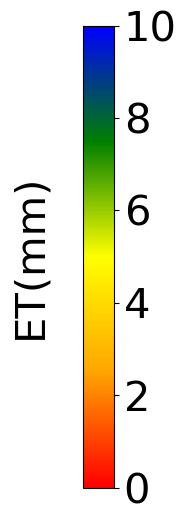

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

# Create a custom colormap with the specified colors
colors = ['red', 'orange', 'yellow', 'green', 'blue']
cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)  # N is the number of color levels

# Create a figure and axis
fig, ax = plt.subplots(figsize=(0.4, 6))  # Adjust the figure size to make the colorbar narrower

# Add a colorbar using the custom colormap
colorbar = ColorbarBase(ax, cmap=cmap, orientation='vertical')
colorbar.set_ticks([0,0.2,0.4,0.6,0.8,1])
custom_ticklabels = ['0', '2', '4', '6', '8',"10"]
colorbar.set_ticklabels(custom_ticklabels,fontsize=30)
# Set colorbar label
colorbar.set_label('ET(mm)',fontsize=30, labelpad=-120, position='left')

# Show the plot
plt.show()

In [134]:
# Set visualization parameters.
folium.Map.add_ee_layer = add_ee_layer
vis_params = {
  'bands': ['ET_24h'],
  'min': 0,
  'max': 7,
    'palette': [
    'a50026', 'd73027', 'f46d43', 'fdae61', 'fee08b', 'ffffbf',
    'd9ef8b', 'a6d96a', '66bd63', '1a9850', '006837',"blue",
  ]}
# vis_params_ndvi = {
#   'bands': ['NDVI'],
#   'min': 0,
#   'max': 0.8,
#     'palette':  [
#     'ffffff', 'ce7e45', 'df923d', 'f1b555', 'fcd163', '99b718', '74a901',
#     '66a000', '529400', '3e8601', '207401', '056201', '004c00', '023b01',
#     '012e01', '011d01', '011301'
#   ]}
# vis_params_rgb = {
#   'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
#   'min': 0.0,
#   'max': 0.3,
# }
# vis_params_dw = {
# 'bands':['B4', 'B3', 'B2'],
#   'min': 0.0,
#   'max': 3000}
# vis_params_hill = {
#   'min': 0.0,
#   'max': 0.65}
# vis_params_cdl = {
# 'bands': ['cropland']}
# vis_params_sen1 = {
# 'bands': ['VV'],
# 'min': -20,
#   'max': -5,
#   'palette': ['blue', 'green', 'yellow', 'orange',"red"]}
# vis_params_vh = {
# 'bands': ['VH'],
# 'min': -30,
#   'max': -10,
#   'palette': ['blue', 'green', 'yellow', 'orange',"red"]}
# Create a folium map object.
my_map = folium.Map(location=[lat, lon], zoom_start=4, height=500)

# Add custom basemaps
basemaps['Google Maps'].add_to(my_map)
basemaps['Google Satellite Hybrid'].add_to(my_map)

# Add the elevation model to the map object.
# my_map.add_ee_layer(b, vis_params_rgb, 'RGB')
my_map.add_ee_layer(b.clip(pvid_ee), vis_params, 'ET')
# my_map.add_ee_layer(b, vis_params_ndvi, 'NDVI')
# my_map.add_ee_layer(ls_first, vis_params_rgb, 'True Color composite Image')
# my_map.add_ee_layer(crop_raster, vis_params_ndvi, 'NDVI_clip')
my_map.add_ee_layer(crop_raster, vis_params, 'ET_clip')
my_map.add_ee_layer(pvid_ee, {}, 'PVID')
# my_map.add_ee_layer(ee.geometry( -114.636762,33.505823), {}, 'PVID point')

# my_map.add_ee_layer(s2Col , vis_params_dw, 'Albedo')
# my_map.add_ee_layer(cdl_clip , vis_params_cdl, 'cdl')
# my_map.add_ee_layer(sen , vis_params_sen1, 'VV')
# my_map.add_ee_layer(sen , vis_params_vh, 'VH')
# my_map.add_ee_layer(s2Image, vis_params_dw, 'Sentinel-2 L1C')
# my_map.add_ee_layer(dwRgbHillshade, vis_params_hill, 'Dynamic World V1 - label hillshade')
# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(my_map)

# Display the map.
display(my_map)
# my_map.save('ee_gezira_et.html')


In [114]:
import os
os.getcwd()

'd:\\Backup\\Rouhin_Lenovo\\TA\\251C'

In [115]:
Map = geemap.Map()
Map.addLayer(b, {
  'bands': ['ET_24h'],
  'min': 0,
  'max': 5,
   'palette': ['red', 'orange', 'yellow', 'green',"blue"]})
Map.to_app("Your Earth Engine App")

AttributeError: 'Map' object has no attribute 'to_app'

In [ ]:
# Get spatial pixel values for the differenct dataset 
print("ls projection rgb",b.select("T_LST_DEM").projection().getInfo())
print("cdl projection rgb",dataset.projection().getInfo())
print("sen projection rgb",sen.select("VH").projection().getInfo())
## Because they dont have same proejction lets make changes
cdl_reproj = dataset.reduceResolution(reducer=ee.Reducer.mode(),maxPixels= 1024).reproject(crs=b.select("T_LST_DEM").projection());
sen_reproj = sen.reduceResolution(reducer=ee.Reducer.mean(),maxPixels= 1024).reproject(crs=b.select("T_LST_DEM").projection());
dyna_reproj = dwCol.first().reduceResolution(reducer=ee.Reducer.mode(),maxPixels= 1024).reproject(crs=b.select("T_LST_DEM").projection());

print("cdl projection rgb",cdl_reproj.projection().getInfo())
print("sen projection rgb",sen_reproj.projection().getInfo())

df_cdl,cdl_clip=convertfeature2df(cdl_reproj, 	38.382768,-121.550491,3000,100)
df_sen,sen_clip=convertfeature2df(sen_reproj, 	38.382768,-121.550491,3000,100)
df_dyna,dyna_clip=convertfeature2df(dyna_reproj, 	38.382768,-121.550491,3000,100)

#Merge these
df_tmp=pd.merge(df_ls, df_sen, on=['lon','lat'])
df_merged=pd.merge(df_tmp,df_cdl,on=["lon","lat"])
df_all=pd.merge(df_merged,df_dyna[['lon', 'lat', 'bare', 'built', 'crops',
       'flooded_vegetation', 'grass', 'label', 'shrub_and_scrub',
       'snow_and_ice', 'trees', 'water']],on=["lon","lat"])

ls projection rgb {'type': 'Projection', 'crs': 'EPSG:32610', 'transform': [30, 0, 494985, 0, -30, 4423215]}
cdl projection rgb {'type': 'Projection', 'crs': 'EPSG:5070', 'transform': [30, 0, -2356095, 0, -30, 3172605]}
sen projection rgb {'type': 'Projection', 'crs': 'EPSG:32610', 'transform': [10, 0, 394369.21918668796, 0, -10, 4374898.786996927]}
cdl projection rgb {'type': 'Projection', 'crs': 'EPSG:32610', 'transform': [30, 0, 494985, 0, -30, 4423215]}
sen projection rgb {'type': 'Projection', 'crs': 'EPSG:32610', 'transform': [30, 0, 494985, 0, -30, 4423215]}


,type_x,id_x,lon,lat,ALFA,B,EA,EA_1,EF,ES,...,bare,built,crops,flooded_vegetation,grass,label,shrub_and_scrub,snow_and_ice,trees,water
0,Feature,0,-121.560237,38.391767,0.122326,0.028580,0.323794,0.323794,0.538003,2.683082,...,0.027866,0.045225,0.397541,0.070468,0.254229,4,0.056060,0.029352,0.041068,0.039840
1,Feature,1,-121.559092,38.391753,0.131735,0.025418,0.323984,0.323984,0.560541,2.682869,...,0.026508,0.038248,0.475851,0.073141,0.211157,4,0.036537,0.026522,0.041508,0.032849
2,Feature,2,-121.557947,38.391738,0.129908,0.026627,0.324173,0.324173,0.547157,2.682657,...,0.025543,0.040950,0.554495,0.056604,0.155932,4,0.035128,0.029305,0.046473,0.038224
3,Feature,3,-121.556802,38.391724,0.160035,0.044915,0.324363,0.324363,0.565064,2.682444,...,0.029946,0.046073,0.565640,0.038565,0.121513,4,0.039676,0.029066,0.043930,0.035875
4,Feature,4,-121.555658,38.391710,0.176773,0.026985,0.324552,0.324552,0.553411,2.682231,...,0.041589,0.035048,0.596413,0.029804,0.103236,4,0.035299,0.026423,0.086449,0.026772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,Feature,394,-121.544553,38.374451,0.143574,0.067905,0.330281,0.330281,0.220544,2.678182,...,0.067534,0.034768,0.658521,0.026752,0.057011,4,0.045680,0.032414,0.026727,0.037802
390,Feature,395,-121.543409,38.374437,0.147850,0.067355,0.330496,0.330496,0.233284,2.677887,...,0.067827,0.035288,0.666444,0.025261,0.043407,4,0.040194,0.036812,0.028656,0.039209
391,Feature,396,-121.542265,38.374422,0.150455,0.073213,0.330712,0.330712,0.241474,2.677592,...,0.077352,0.029326,0.690779,0.025382,0.035173,4,0.032502,0.032205,0.026418,0.038123
392,Feature,397,-121.541120,38.374408,0.145117,0.074340,0.330927,0.330927,0.216878,2.677297,...,0.068489,0.035156,0.679890,0.029462,0.035002,4,0.040072,0.034626,0.028050,0.038751


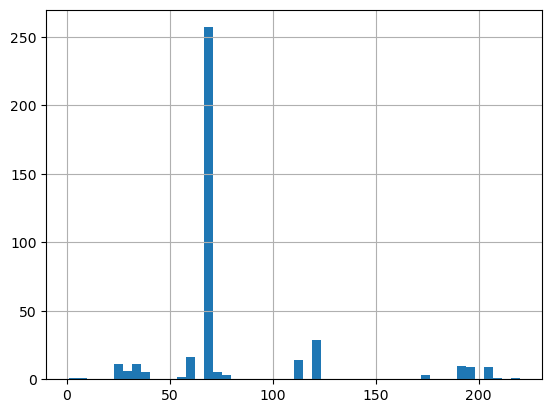

In [141]:
df_all.columns
df_all["cropland"].hist(bins=50)
# df_all[df_all["cropland"]==69]
# df_all

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


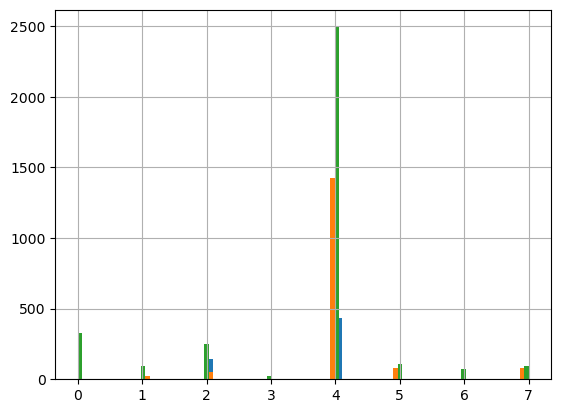

In [82]:
onlyalfa=df_all[df_all.cropland==36]
corn=df_all[df_all.cropland==1]
# print(df_all.cropland.hist(bins=100))
# df_merged[]
# df_merged["VH"].hist(bins=50)
# onlyalfa["VH"].hist(bins=50)
## Lets see if clustering based on the landcover works 
# onlyalfa=
print(onlyalfa["label"].hist(bins=50))
print(corn["label"].hist(bins=50))
print(df_all["label"].hist(bins=100))
# corn=df_merged[df_merged.cropland==1]


<Axes: >

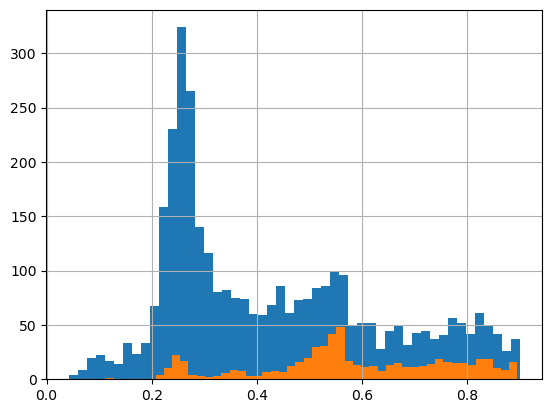

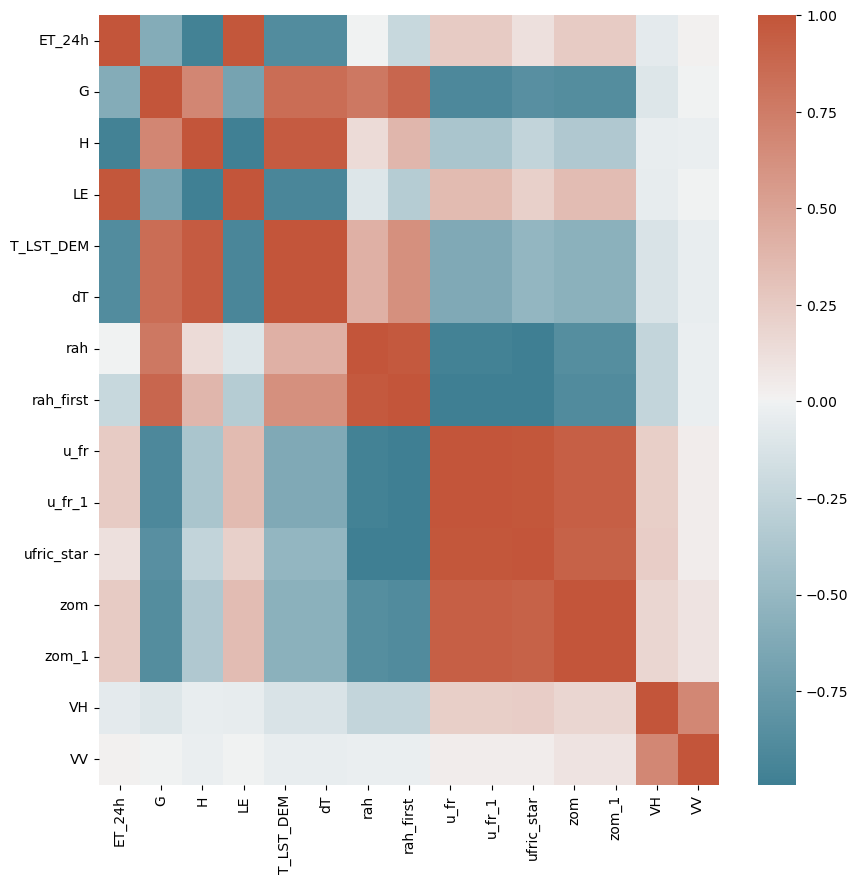

In [18]:
df_merged["NDVI"].hist(bins=50)
onlyalfa["NDVI"].hist(bins=50)
import seaborn as sns
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

corr = onlyalfa[[ 'ET_24h', 'G',  'H', 'LE','T_LST_DEM',  'dT', 'rah', 'rah_first', 'u_fr', 'u_fr_1', 'ufric_star', 'zom', 'zom_1', 'VH','VV']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,cmap=sns.diverging_palette(220, 20, as_cmap=True))
# onlyalfa.columns

<Axes: >

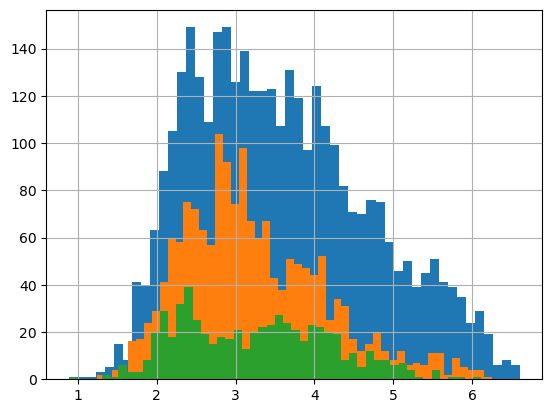

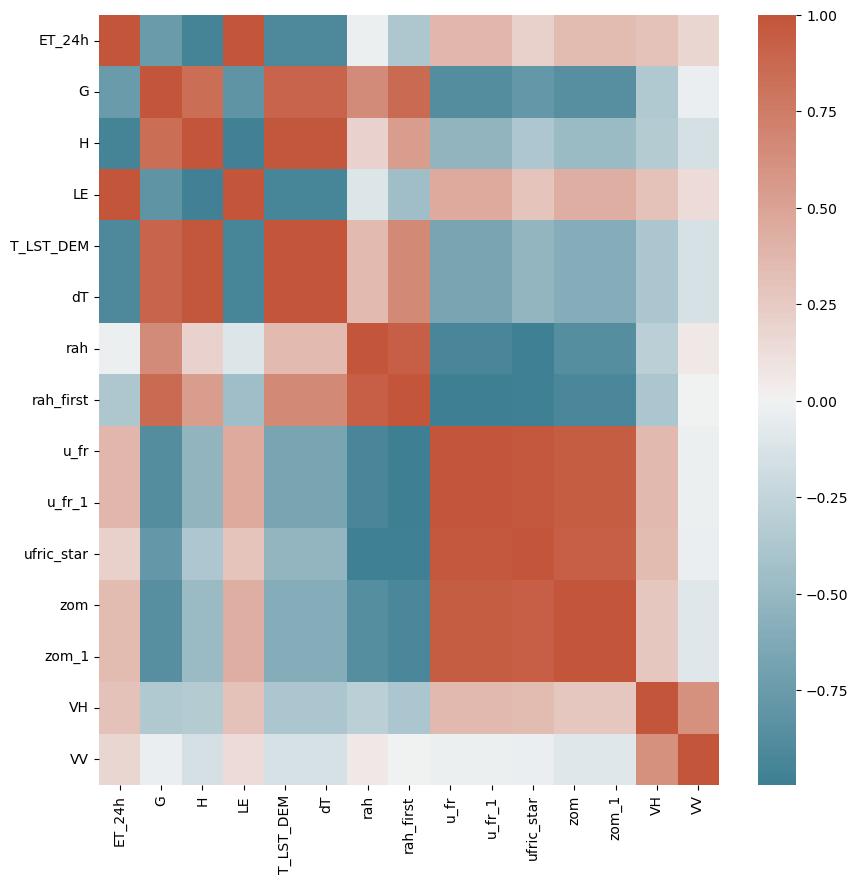

In [19]:
df_merged["ET_24h"].hist(bins=50)
corn["ET_24h"].hist(bins=50)
onlyalfa["ET_24h"].hist(bins=50)

import seaborn as sns
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

corr = corn[[ 'ET_24h', 'G',  'H', 'LE','T_LST_DEM',  'dT', 'rah', 'rah_first', 'u_fr', 'u_fr_1', 'ufric_star', 'zom', 'zom_1', 'VH','VV']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,cmap=sns.diverging_palette(220, 20, as_cmap=True))
# onlyalfa.columns


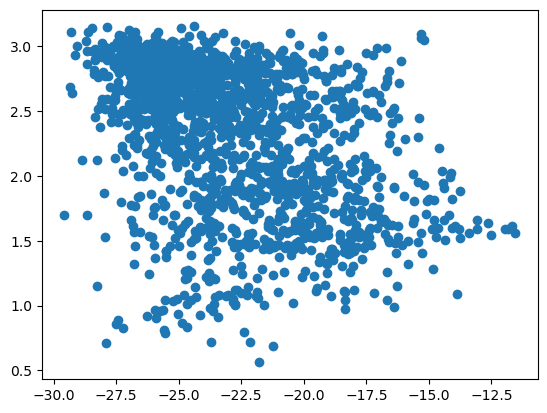

In [29]:
plt.plot(corn["VH"],corn["dT"],"o")
# plt.plot(onlyalfa["VH"],onlyalfa["dT"],"o")


### Lets look at dT using in situ data of H
For that we have a landsat image that coincides with both Bi1 and Var 

In [19]:
## Reading station data 
bi1=pd.read_csv("D:\\Backup\\Rouhin_Lenovo\\US_project\\GEE_SEBAL_Project\\Csv_Files\\Upscaling\\Insitu\\US-Bi1.csv",parse_dates=["Date","Datetime"])
var=pd.read_csv("D:\\Backup\\Rouhin_Lenovo\\US_project\\GEE_SEBAL_Project\\Csv_Files\\Upscaling\\Insitu\\US-Var.csv",parse_dates=["Date","Datetime"])
bi2=pd.read_csv("D:\\Backup\\Rouhin_Lenovo\\US_project\\GEE_SEBAL_Project\\Csv_Files\\Upscaling\\Insitu\\US-Bi2.csv",parse_dates=["Date","Datetime"])

bi1=bi1[bi1.Date=="2022-04-09"]
var=var[var.Date=="2022-04-09"]
bi2=bi2[bi2.Date=="2022-04-09"]
bi2

,Unnamed: 0.1,Unnamed: 0,TIMESTAMP_START,TIMESTAMP_END,CO2,H2O,CH4,FC,FCH4,FC_SSITC_TEST,...,Rnl,Rn_fao,psychro,del,ETo,ET_frac_inst_obs,EF,led_ef,led_eto,led_swin
79680,92352,92352,202204090000,202204090030,416.069010,10.374044,1988.664859,5.406555,-1.192498,1.0,...,0.102152,0.096412,0.068357,0.102443,95.111329,NaN,NaN,NaN,NaN,-1843.889383
79681,92353,92353,202204090030,202204090100,419.081601,10.475982,1986.695552,7.304555,2.091427,2.0,...,0.101027,0.097010,0.068357,0.099443,84.466517,NaN,NaN,NaN,NaN,-2003.831876
79682,92354,92354,202204090100,202204090130,418.840505,10.561112,1994.005920,5.692293,-2.724058,1.0,...,0.100065,0.098630,0.068357,0.097465,80.839723,NaN,NaN,NaN,NaN,-5236.240756
79683,92355,92355,202204090130,202204090200,418.437853,10.383753,1990.214127,5.274624,4.080795,1.0,...,0.099920,0.097911,0.068357,0.095192,74.045373,NaN,NaN,NaN,NaN,-3568.422193
79684,92356,92356,202204090200,202204090230,419.739352,10.362227,1975.832643,4.805129,-13.014581,2.0,...,0.098736,0.097301,0.068357,0.090938,60.116090,NaN,NaN,NaN,NaN,-3071.469006
79685,92357,92357,202204090230,202204090300,421.327134,10.315901,1973.367742,5.015006,-9.170963,1.0,...,0.098071,0.094914,0.068357,0.088382,56.906172,NaN,NaN,NaN,NaN,-1384.481401
79686,92358,92358,202204090300,202204090330,421.258031,10.159291,1994.844626,3.450193,-7.556519,2.0,...,0.097655,0.091916,0.068357,0.086291,51.722937,NaN,NaN,NaN,NaN,-447.118539
79687,92359,92359,202204090330,202204090400,420.258117,10.061936,2002.475274,4.824936,3.286801,2.0,...,0.097682,0.092517,0.068357,0.085888,56.672767,NaN,NaN,NaN,NaN,-544.588397
79688,92360,92360,202204090400,202204090430,422.573868,9.719265,2030.857992,4.923593,-1.310445,1.0,...,0.098052,0.092886,0.068357,0.083257,50.471014,NaN,NaN,NaN,NaN,-804.117959
79689,92361,92361,202204090430,202204090500,422.738940,9.603521,2055.025971,4.569877,8.491835,1.0,...,0.098317,0.092291,0.068357,0.082671,49.415428,NaN,NaN,NaN,NaN,-390.311426


In [20]:
## Get the landsat values
bi1_geom=ee.Geometry.Point([ -121.4993,38.0992]) # US bi1
var_geom=ee.Geometry.Point([-120.9508,38.4133]) # US vaira
bi2_geom=ee.Geometry.Point([-121.5351,38.1091]) # US vaira
bi1_ls=b.reduceRegion(ee.Reducer.first(),bi1_geom,30).getInfo()
bi1_met=met.reduceRegion(ee.Reducer.first(),bi1_geom,30).getInfo()
var_ls=b.reduceRegion(ee.Reducer.first(),var_geom,30).getInfo()
var_met=met.reduceRegion(ee.Reducer.first(),var_geom,30).getInfo()
bi2_ls=b.reduceRegion(ee.Reducer.first(),bi2_geom,30).getInfo()
bi2_met=met.reduceRegion(ee.Reducer.first(),bi2_geom,30).getInfo()

In [21]:
df_bi1_ls= pd.DataFrame.from_dict(bi1_ls.items()).transpose()
df_bi1_ls.columns=df_bi1_ls.iloc[0]
df_bi1_met= pd.DataFrame.from_dict(bi1_met.items()).transpose()
df_bi1_met.columns=df_bi1_met.iloc[0]
##bi2
df_bi2_ls= pd.DataFrame.from_dict(bi2_ls.items()).transpose()
df_bi2_ls.columns=df_bi2_ls.iloc[0]
df_bi2_met= pd.DataFrame.from_dict(bi2_met.items()).transpose()
df_bi2_met.columns=df_bi2_met.iloc[0]
df_var_ls=pd.DataFrame.from_dict(var_ls.items()).transpose()
df_var_ls.columns=df_var_ls.iloc[0]
df_var_met=pd.DataFrame.from_dict(var_met.items()).transpose()
df_var_met.columns=df_var_met.iloc[0]
##merge the met and ls readings 
var_merge=pd.concat([df_var_ls,df_var_met],axis=1).drop(0)
bi1_merge=pd.concat([df_bi1_ls,df_bi1_met],axis=1).drop(0)
bi2_merge=pd.concat([df_bi2_ls,df_bi2_met],axis=1).drop(0)



In [45]:
## Merge the stations readings 
import datetime
var=var[var.Datetime.dt.time==datetime.time(11, 30)]
bi1=bi1[bi1.Datetime.dt.time==datetime.time(11, 30)]
bi2=bi2[bi2.Datetime.dt.time==datetime.time(11, 30)]

print(bi1.columns.tolist())
print(bi1_merge.columns.tolist())
print(var.columns.tolist())
print(bi1[["ZL","USTAR","MO_LENGTH","WS","TA","H","PA","WS"]])
print(bi1_merge[["u_fr","u_fr_1","ufric_star","rah","rah_first","ux_G","dT","AirT_G","T_LST_DEM","NDVI","constant","constant_1","H","LAI"]])
print((bi1_merge["T_LST_DEM"].values-273.15)-bi1["TA"])
## Calculate dt and rah u* in this 

['Unnamed: 0.1', 'Unnamed: 0', 'TIMESTAMP_START', 'TIMESTAMP_END', 'CO2', 'H2O', 'CH4', 'FC', 'FCH4', 'FC_SSITC_TEST', 'FCH4_SSITC_TEST', 'G_inst_af', 'H', 'LE', 'H_SSITC_TEST', 'LE_SSITC_TEST', 'WD', 'WS', 'USTAR', 'ZL', 'TAU', 'MO_LENGTH', 'V_SIGMA', 'W_SIGMA', 'TAU_SSITC_TEST_PI_F', 'PA', 'RH', 'TA', 'VPD_PI', 'T_SONIC', 'T_SONIC_SIGMA', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'TS_1_4_1', 'TS_1_5_1', 'TS_2_1_1', 'TS_2_2_1', 'TS_2_3_1', 'TS_2_4_1', 'TS_2_5_1', 'TS_3_1_1', 'TS_3_2_1', 'TS_3_3_1', 'TS_3_4_1', 'TS_3_5_1', 'SWC_PI_1', 'SWC_PI_2', 'Rn_inst_af', 'PPFD_IN', 'PPFD_OUT', 'SW_IN_inst_af', 'SW_OUT', 'LW_IN', 'LW_OUT', 'P', 'FC_PI_F', 'RECO_PI_F', 'GPP_PI_F', 'FCH4_PI_F', 'H_inst_af', 'LE_inst_af', 'SPEC_RED_IN', 'SPEC_RED_OUT', 'SPEC_NIR_IN', 'SPEC_NIR_OUT', 'NDVI', 'SPEC_PRI_TGT_IN', 'SPEC_PRI_TGT_OUT', 'SPEC_PRI_REF_IN', 'SPEC_PRI_REF_OUT', 'PRI', 'Name', 'Long', 'Lat', 'Elevation', 'State', 'Timezone', 'Veg', 'Clim', 'MAT (°C)', 'MAP (mm)', 'Datetime', 'Date', 'Time', 'doy', 'Al

In [23]:
(1-(16*(2-0.67)/-69.6))**(-0.5)
6.26*(0.54**(-2/3))+(9.11*(0.87**0.5)/0.54**2)
bi1["phi_v"]=(1-(16*(2-0.67)/bi1["MO_LENGTH"]))**(-0.5)
bi1["rah"]=(bi1["phi_v"]/((bi1["phi_v"])**0.5))*(bi1["WS"]/(bi1["USTAR"]**2))+(6.26*(bi1["USTAR"]**(-2/3)))
bi1["rho"]=(-0.0046 *(bi1["TA"]+273.15) ) + 2.5538
bi1["dT_obs"]=bi1["H"]*bi1["rah"]/(1004*bi1["rho"])
bi1["dT_obs"]
# bi1["rho"]

91415    6.324052
Name: dT_obs, dtype: float64

In [24]:
6.26*(0.54**(-2/3))
(bi1["phi_v"]/((bi1["phi_v"])**0.5))*(bi1["WS"]/(bi1["USTAR"]**2))+(6.26*(bi1["USTAR"]**(-2/3)))
bi1["H"]*9.37/(1004*bi1["rho"])
(1.19*1004*(22.26+273.16)*0.54**3)/(0.41*9.81*201)
(1.19*1004*(22.26+273.16)*0.54**3)/(0.41*9.81*201)
(ts_hot*0.15)-45.75
(ts_cold*0.158)-45.75

-0.09468893948000101

In [25]:
print(bi2.columns.tolist())

['Unnamed: 0.1', 'Unnamed: 0', 'TIMESTAMP_START', 'TIMESTAMP_END', 'CO2', 'H2O', 'CH4', 'FC', 'FCH4', 'FC_SSITC_TEST', 'FCH4_SSITC_TEST', 'G_inst_af', 'H', 'LE', 'H_SSITC_TEST', 'LE_SSITC_TEST', 'WD', 'WS', 'USTAR', 'ZL', 'TAU', 'MO_LENGTH', 'V_SIGMA', 'W_SIGMA', 'TAU_SSITC_TEST_PI_F', 'PA', 'RH', 'TA', 'VPD_PI', 'T_SONIC', 'T_SONIC_SIGMA', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'TS_1_4_1', 'TS_1_5_1', 'TS_2_1_1', 'TS_2_2_1', 'TS_2_3_1', 'TS_2_4_1', 'TS_2_5_1', 'TS_3_1_1', 'TS_3_2_1', 'TS_3_3_1', 'TS_3_4_1', 'TS_3_5_1', 'SWC_PI_1', 'SWC_PI_2', 'Rn_inst_af', 'PPFD_IN', 'PPFD_OUT', 'SW_IN_inst_af', 'SW_OUT', 'LW_IN', 'LW_OUT', 'P', 'PPFD_DIF', 'FC_PI_F', 'RECO_PI_F', 'GPP_PI_F', 'FCH4_PI_F', 'H_inst_af', 'LE_inst_af', 'SPEC_RED_IN', 'SPEC_RED_OUT', 'SPEC_NIR_IN', 'SPEC_NIR_OUT', 'SPEC_PRI_TGT_IN', 'SPEC_PRI_TGT_OUT', 'SPEC_PRI_REF_IN', 'SPEC_PRI_REF_OUT', 'Name', 'Long', 'Lat', 'Elevation', 'State', 'Timezone', 'Veg', 'Clim', 'MAT (°C)', 'MAP (mm)', 'Datetime', 'Date', 'Time', 'doy', 'Albed

In [49]:
def calculate_dt(df,h_col,ta_col,ws_col):
    df["rho"]=(-0.0046 *(df[ta_col]+273.15) ) + 2.5538
    df["mr"]=0.622*(df["ea"]/(df["PA"]-df["ea"]))
    df["Tv"] = (1 + 0.61*df["mr"])*(df["TA"]+273.15)
    df["mo_l"]=-(df["rho"]*1004*(df["Tv"])*df["USTAR"]**3)/(0.41*9.81*df[h_col])
    df["phi_v"]=(1-(16*(2-0.67)/df["mo_l"]))**(-0.5)
    df["rah"]=(df["phi_v"]/((df["phi_v"])**0.5))*(df[ws_col]/(df["USTAR"]**2))+(6.26*(df["USTAR"]**(-2/3)))
    df["dT_obs"]=df[h_col]*df["rah"]/(1004*df["rho"])
    return df
bi1=calculate_dt(bi1,"H","TA","WS")
var=calculate_dt(var,"H","TA","WS")
bi2["TA"]=22.165737
bi2["ea"]=0.390718 
bi2=calculate_dt(bi2,"H","TA","WS")

print(var_merge[["u_fr","u_fr_1","ufric_star","rah","rah_first","ux_G","dT","AirT_G","T_LST_DEM","NDVI","constant","constant_1","H","EA","LAI"]])
print(var[["dT_obs","USTAR","mo_l","rah","H","LE_inst_af","TA","ea","ZL","WS"]])
(var_merge["T_LST_DEM"].values-273.15)-var["TA"]

0      u_fr    u_fr_1 ufric_star        rah  rah_first      ux_G        dT  \
1  0.557516  0.557516   0.687789  10.013863  13.105748  3.221872  3.276975   

0     AirT_G   T_LST_DEM      NDVI  constant constant_1           H        EA  \
1  20.745573  309.654267  0.697687  0.158334 -45.751808  376.017014  0.628195   

0       LAI  
1  0.869532  
          dT_obs    USTAR       mo_l        rah       H  LE_inst_af     TA  \
109079  4.564083  0.43209 -35.096687  27.098856  203.13      179.75  20.88   

              ea       ZL      WS  
109079  0.604593 -0.05641  3.3937  


109079    15.624267
Name: TA, dtype: object

In [42]:
print(bi2_merge[["u_fr","u_fr_1","ufric_star","rah","rah_first","ux_G","dT","AirT_G","T_LST_DEM","NDVI","constant","constant_1","H","EA","LAI"]])
print(bi2[["dT_obs","USTAR","mo_l","rah","H","LE_inst_af","WS","TA","ZL"]])
(bi2_merge["T_LST_DEM"].values-273.15)-bi2["TA"]

0      u_fr    u_fr_1 ufric_star        rah  rah_first      ux_G        dT  \
1  0.584797  0.584797   0.683877  10.218199  12.494358  3.927595  2.368015   

0     AirT_G   T_LST_DEM      NDVI  constant constant_1           H        EA  \
1  22.165737  303.913489  0.306579  0.158334 -45.751808  271.456056  0.390718   

0       LAI  
1  0.140023  
         dT_obs     USTAR       mo_l        rah           H  LE_inst_af  \
79703  9.018949  0.515304 -50.971191  45.689816  236.899675  195.466719   

              WS         TA        ZL  
79703  10.416242  22.165737 -0.099783  


79703    8.597752
Name: TA, dtype: object

In [28]:
import os
os.chdir("D:\\Backup\\Rouhin_Lenovo\\US_project\\GEE_SEBAL_Project\\Csv_Files\\Upscaling\\Insitu\\")
am_files=os.listdir()
hr_data=[]
for i in range(len(am_files)):
    hr_data.append(pd.read_csv(am_files[i]))
hr_data[0].columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'TIMESTAMP_START', 'TIMESTAMP_END',
       'TAU_1_1_1', 'H_inst_af', 'LE_inst_af', 'FC_1_1_1', 'WS_1_1_1',
       'WS_MAX_1_1_1',
       ...
       'Rnl', 'Rn_fao', 'psychro', 'del', 'ETo', 'ET_frac_inst_obs', 'EF',
       'led_ef', 'led_eto', 'led_swin'],
      dtype='object', length=190)

In [29]:
count=0
for i in range(len(hr_data)):
    if "MO_LENGTH" in hr_data[i].columns:
        print("True",i,hr_data[i]["Name"].iloc[0])
        count=count+1
print(count,len(hr_data))

True 1 US-Bi1
True 2 US-Bi2
True 6 US-Jo1
True 26 US-ONA
True 27 US-Rls
True 28 US-Rms
True 33 US-Rwf
True 34 US-Rws
True 39 US-Tw3
True 40 US-UiA
True 41 US-UiB
True 42 US-UiC
12 85


In [112]:
### Doing this to generate pivot irrigatoin rasters 
# Get a <10% cloudy landsat image of the central valley 
# LANDSAT/LC08/C02/T1_L2/LC08_043034_20220402
# geometry=ee.Geometry.Point([-121.189405,37.615426])
# geometry=ee.Geometry.Point([-120.9508,38.4133]) # US vaira
geometry=ee.Geometry.Point([ -118.958584,35.277833]) # Neutral to accomodate Bi1 and Vaira
# Get the image collection 
ls=ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterDate("2022-04-01","2022-09-30").filterMetadata('CLOUD_COVER', 'less_than', 5).filterBounds(geometry);
print("The image collection has", ls.size().getInfo(), "images")
## Scale the images 
## Why do we need to scale? (Refer the slides)
def applyScaleFactors(image):
        opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2);
        thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0);
        return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)
ls=ls.map(applyScaleFactors)
#Get the first image
ls_first=ls.first()
## Rune sebal
b=runsebal(ls_first)
def convertfeature2df(image,lat,lon,radius,scale):
    geom=ee.Geometry.Point( lon, lat)
    pointBuffer = geom.buffer(radius)
    crop_ls=image.clip(pointBuffer)
    # vectors = crop_ls.sample(region=crop_ls.geometry().bounds().getInfo(),geometries=True,scale =scale)
    ## Convert to dataframe
    # df = pd.DataFrame(vectors.getInfo()['features'])
    # df["lon"]=df.apply(lambda row : row["geometry"]["coordinates"][0]
                    #  , axis = 1)
    # df["lat"]=df.apply(lambda row : row["geometry"]["coordinates"][1]
                    #  , axis = 1)
    # df = df.join(pd.DataFrame(df['properties'].tolist()))
    # df.drop(['properties','geometry'], axis=1, inplace=True)
    return crop_ls
crop_raster=convertfeature2df(b, 	35.277833,-118.95866,400,10)


The image collection has 10 images
LC08_L1TP_041036_20220506_20220512_02_T1
64.40943476
1828
['UB', 'B', 'GR', 'R', 'NIR', 'SWIR_1', 'SWIR_2', 'ST_B10', 'pixel_qa']
['UB', 'B', 'GR', 'R', 'NIR', 'SWIR_1', 'SWIR_2', 'ST_B10', 'pixel_qa']
['UB', 'B', 'GR', 'R', 'NIR', 'SWIR_1', 'SWIR_2', 'ST_B10', 'pixel_qa', 'ALFA']
64.40943476
['AirT_G']
It's a miracle
{'ndvi': 0.7985209226608276, 'sum': 430621, 'temp': 295.70483642, 'x': -117.47827692705447, 'y': 34.20815887338591}


In [85]:
ls_first.get('L1_LANDSAT_PRODUCT_ID').getInfo()

'LC08_L1TP_041036_20220506_20220512_02_T1'

In [118]:
imgVV = ee.ImageCollection('COPERNICUS/S1_GRD').filter(ee.Filter.date("2022-05-06","2022-09-09")).filterBounds(ee.Geometry.Point( -118.958584,35.277833)).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')).filter(ee.Filter.eq('instrumentMode', 'IW')).map(mask_sen1)
desc = imgVV.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'));
asc = imgVV.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'));
sen=asc.first()
print(sen.getInfo())
crop_sen=convertfeature2df(sen, 	35.277833,-118.95879,400,10)


{'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [29443, 22033], 'crs': 'EPSG:32611', 'crs_transform': [10, 0, 115500.66914559412, 0, -10, 3925204.0321869003]}, {'id': 'VH', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [29443, 22033], 'crs': 'EPSG:32611', 'crs_transform': [10, 0, 115500.66914559412, 0, -10, 3925204.0321869003]}, {'id': 'angle', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [21, 10], 'crs': 'EPSG:32611', 'crs_transform': [13020.480299957271, -3157.301892745949, 148236.073756675, 2005.4696664754301, 20197.16488752095, 3710842.4126176643]}], 'version': 1691519111718894, 'id': 'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20220506T015845_20220506T015910_043084_052511_0B17', 'properties': {'SNAP_Graph_Processing_Framework_GPF_vers': '8.0.3', 'SLC_Processing_facility_org': 'ESA', 'SLC_Processing_facility_country': 'Italy', 'GRD_Post_Processing_facility_org': 'ESA', 't

In [37]:
crop_raster=b.clip(pvid_ee)

In [42]:
# Set visualization parameters.
folium.Map.add_ee_layer = add_ee_layer
vis_params = {
  'bands': ['ET_24h'],
  'min': 0,
  'max': 8,
   'palette': ['red', 'orange', 'yellow', 'green',"blue"]}
# vis_params_dw = {
# 'bands':['B4', 'B3', 'B2'],
#   'min': 0.0,
#   'max': 3000}
# vis_params_hill = {
#   'min': 0.0,
#   'max': 0.65}
# vis_params_cdl = {
# 'bands': ['cropland']}
# vis_params_sen1 = {
# 'bands': ['VV'],
# 'min': -20,
#   'max': -5,
#   'palette': ['blue', 'green', 'yellow', 'orange',"red"]}
# vis_params_vh = {
# 'bands': ['VH'],
# 'min': -30,
#   'max': -10,
#   'palette': ['blue', 'green', 'yellow', 'orange',"red"]}
# Create a folium map object.
my_map = folium.Map(location=[35, -120], zoom_start=4, height=500)

# Add custom basemaps
basemaps['Google Maps'].add_to(my_map)
basemaps['Google Satellite Hybrid'].add_to(my_map)

# Add the elevation model to the map object.
# my_map.add_ee_layer(b, vis_params, 'ET')
my_map.add_ee_layer(crop_raster, vis_params, 'ET_clip')
my_map.add_ee_layer(pvid_ee, {}, 'PVID')

# my_map.add_ee_layer(s2Col , vis_params_dw, 'Albedo')
# my_map.add_ee_layer(cdl_clip , vis_params_cdl, 'cdl')
# my_map.add_ee_layer(crop_sen , vis_params_sen1, 'VV')
# my_map.add_ee_layer(crop_sen , vis_params_vh, 'VH')
# my_map.add_ee_layer(s2Image, vis_params_dw, 'Sentinel-2 L1C')
# my_map.add_ee_layer(dwRgbHillshade, vis_params_hill, 'Dynamic World V1 - label hillshade')
# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(my_map)

# Display the map.
display(my_map)

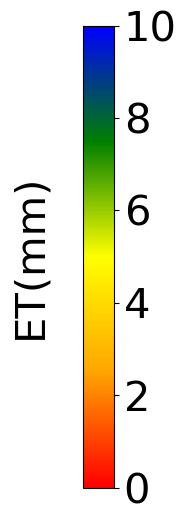

In [48]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

# Create a custom colormap with the specified colors
colors = ['red', 'orange', 'yellow', 'green', 'blue']
cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)  # N is the number of color levels

# Create a figure and axis
fig, ax = plt.subplots(figsize=(0.4, 6))  # Adjust the figure size to make the colorbar narrower

# Add a colorbar using the custom colormap
colorbar = ColorbarBase(ax, cmap=cmap, orientation='vertical')
colorbar.set_ticks([0,0.2,0.4,0.6,0.8,1])
custom_ticklabels = ['0', '2', '4', '6', '8',"10"]
colorbar.set_ticklabels(custom_ticklabels,fontsize=30)
# Set colorbar label
colorbar.set_label('ET(mm)',fontsize=30, labelpad=-120, position='left')

# Show the plot
plt.show()

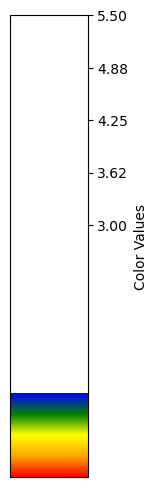

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

# Create a custom colormap with the specified colors
colors = ['red', 'orange', 'yellow', 'green', 'blue']
cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)  # N is the number of color levels

# Create a figure and axis
fig, ax = plt.subplots(figsize=(1, 6))  # Adjust the figure size to make the colorbar narrower

# Add a colorbar using the custom colormap
colorbar = ColorbarBase(ax, cmap=cmap, orientation='vertical')

# Set custom tick locations and labels
tick_positions = np.linspace(3, 5.5, num=5)  # Generating 5 tick positions from 3 to 5.5
colorbar.set_ticks(tick_positions)
colorbar.set_ticklabels([f'{tick:.2f}' for tick in tick_positions])  # Format the labels to two decimal places

# Set colorbar label
colorbar.set_label('Color Values')

# Show the plot
plt.show()
